In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import gc


In [ ]:
df = pd.read_csv(filepath_or_buffer="./438_Final_data_v3.csv")
df.head()

,Label,Messages,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,h,ধন্যবাদ বাংলা দেশ পুলিশ এবং গণমাধ্যম(ফেসবুক) ক...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p,"১জিবি মাত্র ৩১ টাকা, মেয়াদ ৭ দিন,অফারটি নিতে ড...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,h,তোরে বাংলায় জুতা নিয়ে অপেক্ষা করছে। পাইলে বা...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p,"১জিবি ১৪টাকা(সর্বচ্চো একবার),মেয়াদ ৭দিন। ডায়াল...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,h,Ooo bed ridden ey? Wat are YOU tinking of?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.iloc[:, :2]

In [ ]:
print(df.columns)

# Print the number of rows
print(df.shape[0])


Index(['Label', 'Messages'], dtype='object')
2876


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df['Label'].value_counts()

h    1459
p    1417
Name: Label, dtype: int64

In [ ]:
df.head()

,Label,Messages
0,p,"২২ মার্চ ২০২৩ বিশ্ব পানি দিবস, এবারের প্রতিপাদ..."
1,p,“করলে জাটকা সংরক্ষণ-বাড়বে ইলিশের উৎপাদন“ ০১-০...
2,p,"৫০০মিনিট ২৮৮টাকা মেয়াদ ৩০দিন, নিতে ডায়াল করুন ..."
3,h,"আমি আশ্চর্য হই,ফেইসবুকের কিছু লেখকের কান্ড দেখ..."
4,h,শীর্ষ ব্যবসায়ী এফবিসিসিআই সংগঠনের পরিচালক নাটো...


In [ ]:
from torchtext import data
from sklearn import preprocessing
X = df["Messages"].values
y = df["Label"].values

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
_ = gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
"""
Basic Tokenization
Basic tokenization tokenize sentence using white spaces, punctuation mark
To check Original Code: https://github.com/google-research/bert/blob/master/tokenization.py
"""
import six
import unicodedata


def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if six.PY3:
        if isinstance(text, str):
            return text
        elif isinstance(text, bytes):
            return text.decode("utf-8", "ignore")
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    elif six.PY2:
        if isinstance(text, str):
            return text.decode("utf-8", "ignore")
        elif isinstance(text, unicode):
            return text
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    else:
        raise ValueError("Not running on Python2 or Python 3?")


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    # print("Text: ", text)
    if not text:
        return []
    tokens = text.split()
    # print("tokens : ", tokens)
    return tokens


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if (
        (cp >= 33 and cp <= 47)
        or (cp >= 58 and cp <= 64)
        or (cp >= 91 and cp <= 96)
        or (cp >= 123 and cp <= 126)
    ):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False


class BasicTokenizer:
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = convert_to_unicode(text)

        orig_tokens = whitespace_tokenize(text)
        # print("original tokens: ", orig_tokens)
        split_tokens = []
        for token in orig_tokens:
            # if self.do_lower_case:
            #   token = token.lower()
            #   token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        # print("split tokens: ", split_tokens)
        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]


In [ ]:
tokenizer = BasicTokenizer()
X_t = []
for i in range(len(X)):
    tknz = tokenizer.tokenize(str(X[i]).strip())
    X_t.append(tknz)


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [ ]:
vocab = build_vocab_from_iterator(iter(X_t), specials=["<unk>"])


vocab.set_default_index(vocab["<unk>"])


In [ ]:
X = []
for i in range(len(X_t)):
    tknz = vocab(X_t[i])
    X.append(torch.tensor(tknz))


In [ ]:
from torch.nn.utils.rnn import pad_sequence
X = pad_sequence(X, batch_first=True)


In [ ]:
# X, y
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = MultinomialNB(force_alpha=True)

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
clf.fit(X_train, y_train)
print("score on test: " + str(clf.score(X_test, y_test)))
print("score on train: "+ str(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)

accuracy_test = clf.score(X_test, y_test) * 100
accuracy_train = clf.score(X_train, y_train) * 100

clf_model = clf.fit(X_train, y_train)
y_clf_proba = clf_model.predict_proba(X_test)
y_clf_pred = np.where(y_clf_proba[:,1] > 0.5, 1, 0)

print("Accuracy on test set: {:.2f}%".format(accuracy_test))
print("Accuracy on train set: {:.2f}%".format(accuracy_train))

sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False)
plt.title('MultinomialNB: {:.2f}%'.format(accuracy_test))
plt.xlabel('true class')
plt.ylabel('predicted class')
print('Classification Report:',classification_report(y_test.reshape(-1,1), y_pred))

NameError: ignored

score on test: 0.831981460023175
score on train: 0.8892200695479384
Accuracy on test set: 83.20%
Accuracy on train set: 88.92%
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.85      0.84       450
           1       0.83      0.81      0.82       413

    accuracy                           0.83       863
   macro avg       0.83      0.83      0.83       863
weighted avg       0.83      0.83      0.83       863



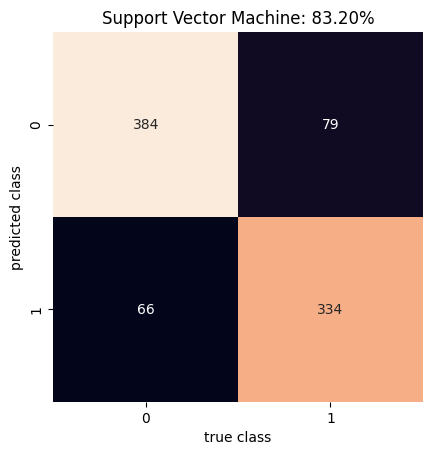

In [ ]:
from sklearn.svm import SVC
svm=SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))

y_pred = svm.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False)

accuracy_test = svm.score(X_test, y_test) * 100
accuracy_train = svm.score(X_train, y_train) * 100

svm_model = svm.fit(X_train, y_train)
y_svm_proba = svm_model.predict_proba(X_test)
y_svm_pred = np.where(y_svm_proba[:,1] > 0.5, 1, 0)

print("Accuracy on test set: {:.2f}%".format(accuracy_test))
print("Accuracy on train set: {:.2f}%".format(accuracy_train))

plt.title('Support Vector Machine: {:.2f}%'.format(accuracy_test))
plt.xlabel('true class')
plt.ylabel('predicted class')
print('Classification Report:',classification_report(y_test.reshape(-1,1), y_pred))

score on test: 0.9188876013904983
score on train: 1.0
Accuracy on test set: 91.89%
Accuracy on train set: 100.00%
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.98      0.93       450
           1       0.98      0.85      0.91       413

    accuracy                           0.92       863
   macro avg       0.93      0.92      0.92       863
weighted avg       0.93      0.92      0.92       863



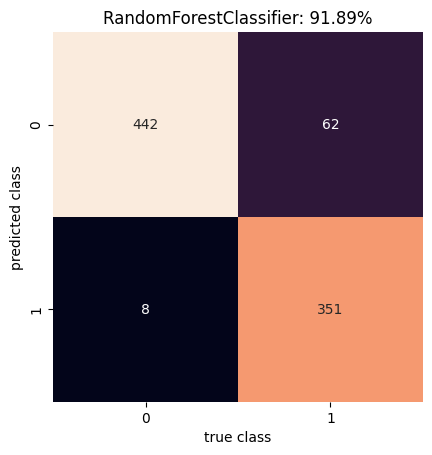

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', criterion='gini', max_features='log2',min_samples_split=3)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

y_pred = rf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)

accuracy_test = rf.score(X_test, y_test) * 100
accuracy_train = rf.score(X_train, y_train) * 100

rf_model = rf.fit(X_train, y_train)
y_rf_proba = rf_model.predict_proba(X_test)
y_rf_pred = np.where(y_rf_proba[:,1] > 0.5, 1, 0)

print("Accuracy on test set: {:.2f}%".format(accuracy_test))
print("Accuracy on train set: {:.2f}%".format(accuracy_train))

sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False)
plt.title('RandomForestClassifier: {:.2f}%'.format(accuracy_test))
plt.xlabel('true class')
plt.ylabel('predicted class')
print('Classification Report:',classification_report(y_test.reshape(-1,1), y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score on test: 0.7555040556199305
score on train: 0.8032786885245902
Accuracy on test set: 75.55%
Accuracy on train set: 80.33%
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.68      0.74       450
           1       0.71      0.84      0.77       413

    accuracy                           0.76       863
   macro avg       0.76      0.76      0.75       863
weighted avg       0.77      0.76      0.75       863



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


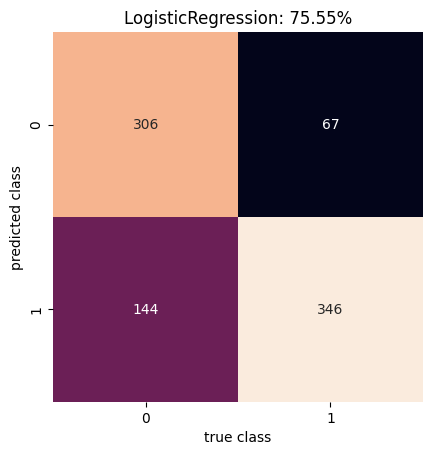

In [ ]:
from sklearn.linear_model import LogisticRegression


lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))

y_pred = lr.predict(X_test)
mat = confusion_matrix(y_test, y_pred)

accuracy_test = lr.score(X_test, y_test) * 100
accuracy_train = lr.score(X_train, y_train) * 100

lr_model = lr.fit(X_train, y_train)
y_lr_proba = lr_model.predict_proba(X_test)
y_lr_pred = np.where(y_lr_proba[:,1] > 0.5, 1, 0)

print("Accuracy on test set: {:.2f}%".format(accuracy_test))
print("Accuracy on train set: {:.2f}%".format(accuracy_train))

sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False)
plt.title('LogisticRegression: {:.2f}%'.format(accuracy_test))
plt.xlabel('true class')
plt.ylabel('predicted class')
print('Classification Report:',classification_report(y_test.reshape(-1,1), y_pred))

**Neural networks**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=150, random_state=42)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8563151796060255


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve, train_test_split

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686

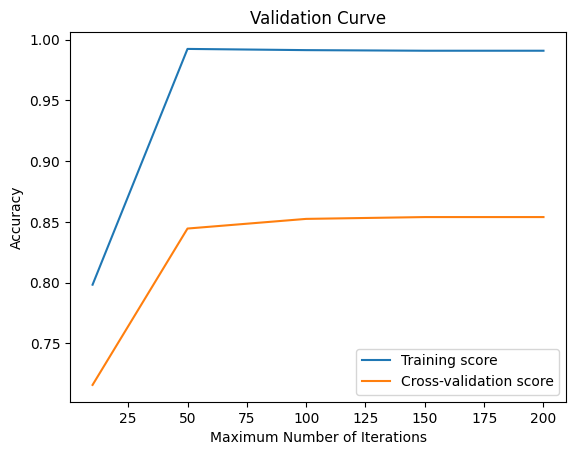

In [ ]:
param_range = [10, 50, 100, 150, 200]
train_scores, test_scores = validation_curve(
    MLPClassifier(random_state=42),
    X_train,
    y_train,
    param_name='max_iter',
    param_range=param_range,
    cv=3
)

plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation Curve')
plt.xlabel('Maximum Number of Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Accuracy on test set: 85.63%
Accuracy on train set: 98.76%
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.85      0.86       450
           1       0.84      0.86      0.85       413

    accuracy                           0.86       863
   macro avg       0.86      0.86      0.86       863
weighted avg       0.86      0.86      0.86       863



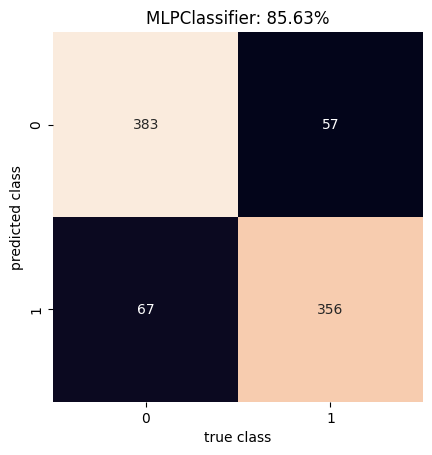

In [ ]:
y_pred = nn.predict(X_test)

# Generate a confusion matrix
mat = confusion_matrix(y_test, y_pred)

accuracy_test = nn.score(X_test, y_test) * 100
accuracy_train = nn.score(X_train, y_train) * 100

print("Accuracy on test set: {:.2f}%".format(accuracy_test))
print("Accuracy on train set: {:.2f}%".format(accuracy_train))

nn_model = nn.fit(X_train, y_train)
y_nn_proba = nn_model.predict_proba(X_test)
y_nn_pred = np.where(y_nn_proba[:,1] > 0.5, 1, 0)

sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False)
plt.title('MLPClassifier: {:.2f}%'.format(accuracy_test))
plt.xlabel('true class')
plt.ylabel('predicted class')
print('Classification Report:',classification_report(y_test.reshape(-1,1), y_pred))

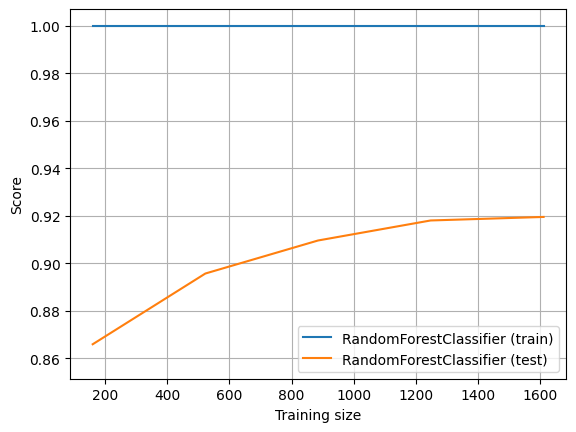

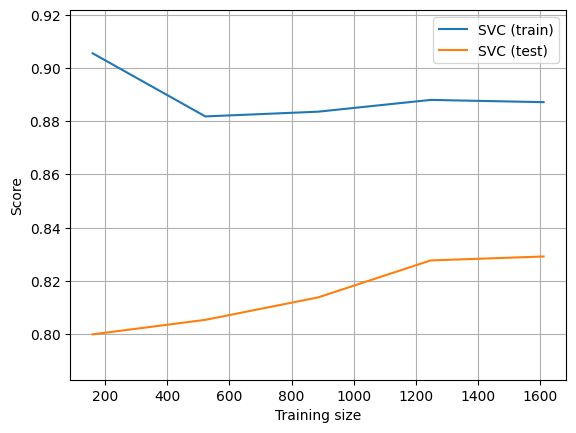

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

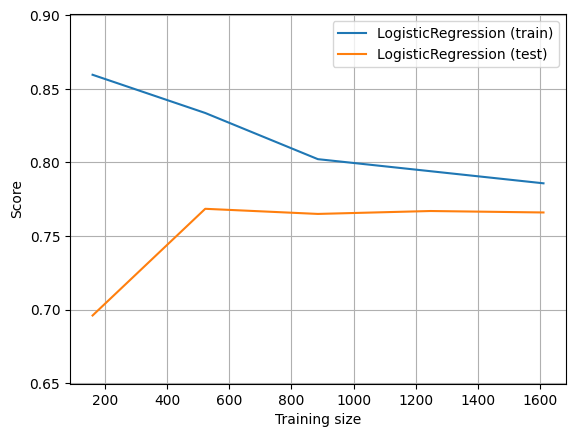

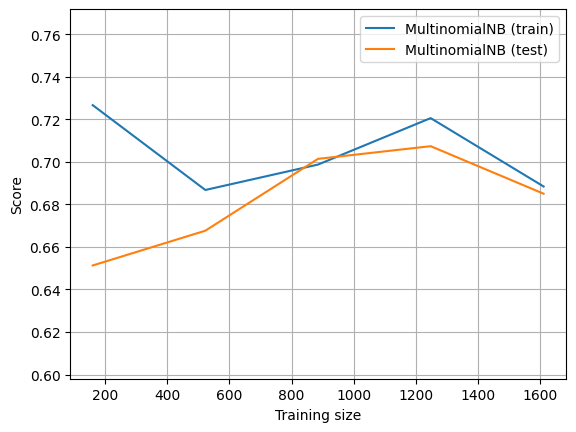

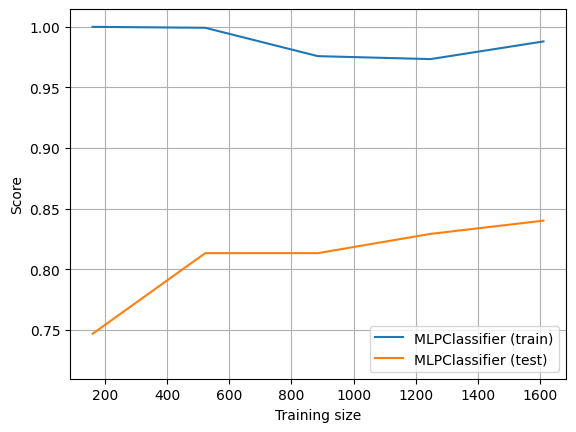

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(models, X, y):
    for model in models:
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)


        plt.plot(train_sizes, train_scores_mean, label=f"{model.__class__.__name__} (train)")
        plt.plot(train_sizes, test_scores_mean, label=f"{model.__class__.__name__} (test)")
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0)
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0)
        plt.xlabel("Training size")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid()
        plt.show()


X, y = X_train, y_train

models = [RandomForestClassifier(), SVC(), LogisticRegression(max_iter=1500),  MultinomialNB(force_alpha=True), MLPClassifier(hidden_layer_sizes=(100,), max_iter=150, random_state=42)]
plot_learning_curves(models, X, y)

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scikitplot as skplt

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

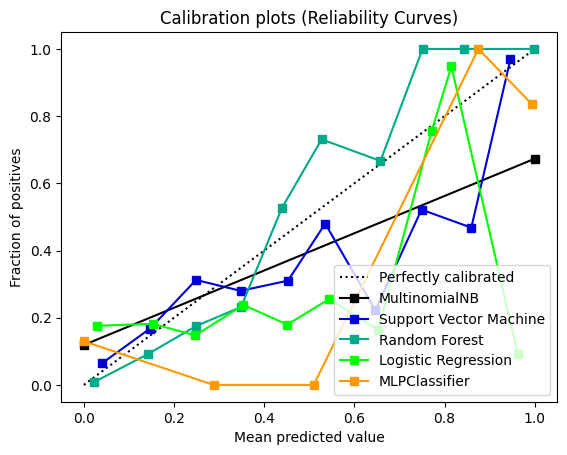

In [ ]:

probas_list = [y_clf_proba,y_svm_proba,y_rf_proba,y_lr_proba,y_nn_proba]
clf_names = ['MultinomialNB','Support Vector Machine', 'Random Forest', 'Logistic Regression','MLPClassifier']
skplt.metrics.plot_calibration_curve(y_test, probas_list = probas_list, clf_names = clf_names)

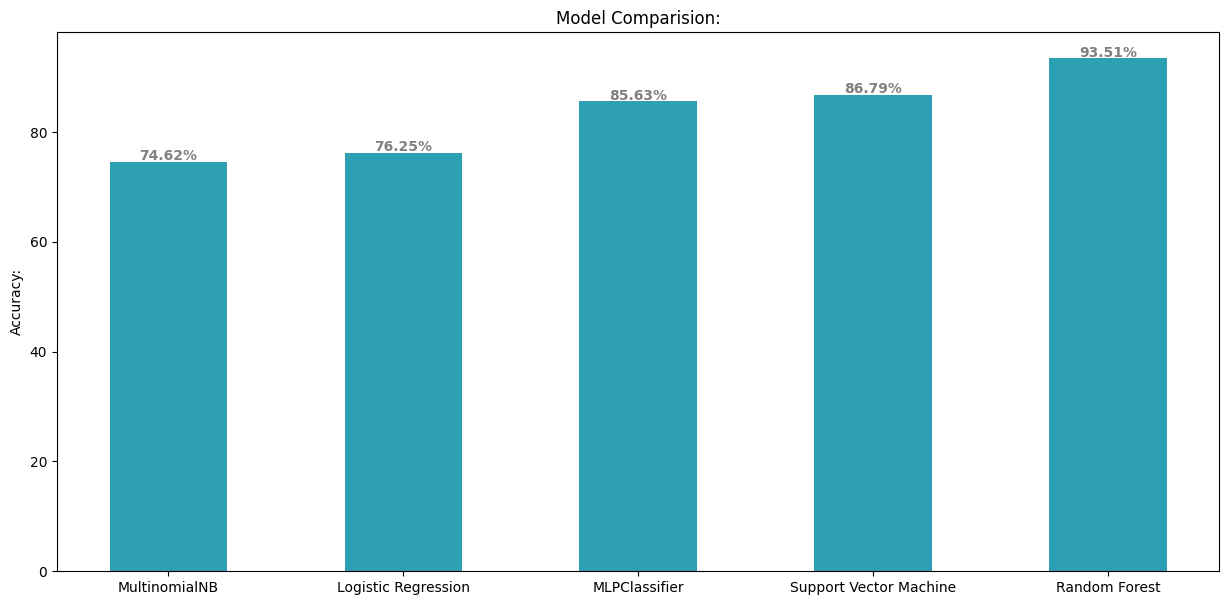

In [ ]:
import matplotlib.pyplot as plt
plotter = {'MultinomialNB':74.62,'Logistic Regression':76.25,'MLPClassifier':85.63, 'Support Vector Machine':86.79,'Random Forest':93.51}
courses = list(plotter.keys())
values = list(plotter.values())

fig = plt.figure(figsize = (15, 7))

# creating the bar plot
plt.bar(courses, values, color ='#2DA0B4', width = 0.5)

# adding values on top of bars
for i, v in enumerate(values):
    plt.text(i, v+1, str(v)+ '%', color='grey',fontsize = 10, fontweight='bold', ha='center', va='center')

#plt.xlabel()
plt.ylabel("Accuracy:")
plt.title("Model Comparision:")
plt.show()